In [187]:
# Cell 1 - Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [188]:
# Cell 2 - Load your CSV files and preprocess
years = list(range(2018, 2024))  # 2018–2023 as training
dfs = []
for year in years:
    df = pd.read_csv('../../data/clean/complex/final/player_data_{}.csv'.format(year))
    df['Year'] = year
    df = df[df['Rank'] <= 20]  # Only ranked players are labeled
    df['Class'] = df['Rank'] - 1  # Convert rank 1–20 → class 0–19
    dfs.append(df)

train_df = pd.concat(dfs, ignore_index=True)

test_df = pd.read_csv('../../data/clean/complex/final/player_data_2024.csv')
test_df['Year'] = 2024

# Clean features
id_cols = ['Player', 'HLTV_ID', 'Rank', 'Year']
feature_cols = [c for c in train_df.columns if c not in id_cols + ['Class']]
shared_cols = list(set(feature_cols) & set(test_df.columns))

# Fix missing/invalid values
train_df[shared_cols] = train_df[shared_cols].replace(-1.0, np.nan).fillna(train_df[shared_cols].mean())
test_df[shared_cols] = test_df[shared_cols].replace(-1.0, np.nan).fillna(train_df[shared_cols].mean())

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[shared_cols])
y_train = train_df['Class'].values
X_test = scaler.transform(test_df[shared_cols])


In [189]:
# Cell 3 - Create DataLoaders
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [190]:
# Cell 4 - MLP to replace plain SoftmaxRegression
class MLPOrdinal(nn.Module):
    def __init__(self, input_dim, num_classes=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)  # still outputs logits for softmax
        )

    def forward(self, x):
        return self.net(x)  # returns raw logits


Epoch 0 | Loss: 29.0390
Epoch 10 | Loss: 7.8643
Epoch 20 | Loss: 4.0661
Epoch 30 | Loss: 2.2171
Epoch 40 | Loss: 1.4115
Epoch 50 | Loss: 0.9308
Epoch 60 | Loss: 0.6225
Epoch 70 | Loss: 0.4369
Epoch 80 | Loss: 0.3161
Epoch 90 | Loss: 0.1922
Epoch 100 | Loss: 0.1604
Epoch 110 | Loss: 0.1414
Epoch 120 | Loss: 0.1800
Epoch 130 | Loss: 0.0960
Epoch 140 | Loss: 0.0683
Epoch 150 | Loss: 0.1747
Epoch 160 | Loss: 0.0615
Epoch 170 | Loss: 0.1193
Epoch 180 | Loss: 0.3627
Epoch 190 | Loss: 0.0573
Epoch 200 | Loss: 0.0397
Epoch 210 | Loss: 0.0262
Epoch 220 | Loss: 0.0221
Epoch 230 | Loss: 0.0195
Epoch 240 | Loss: 0.1431
Epoch 250 | Loss: 0.3366
Epoch 260 | Loss: 0.0337
Epoch 270 | Loss: 0.0167
Epoch 280 | Loss: 0.0146
Epoch 290 | Loss: 0.0173
Epoch 300 | Loss: 0.0152
Epoch 310 | Loss: 0.0317
Epoch 320 | Loss: 0.1468
Epoch 330 | Loss: 0.1964
Epoch 340 | Loss: 0.0516
Epoch 350 | Loss: 0.0124
Epoch 360 | Loss: 0.0155
Epoch 370 | Loss: 0.0255
Epoch 380 | Loss: 0.0213
Epoch 390 | Loss: 0.0084
Epoch 400 

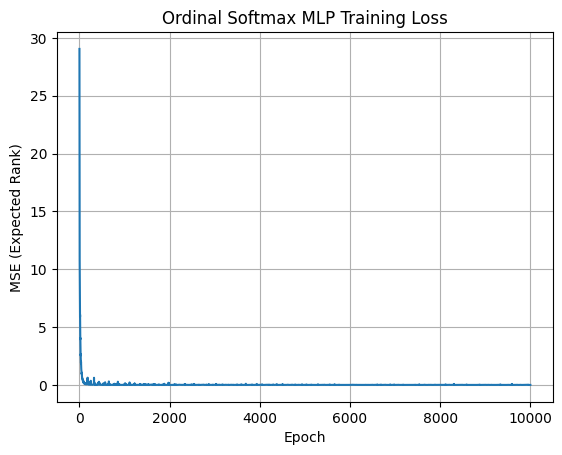

In [191]:
# Cell 5 - Training loop with expected rank and MSE loss
input_dim = X_train.shape[1]
num_classes = 20
model = MLPOrdinal(input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# True rank labels as float for MSE against expected rank
y_train_rank = train_df['Rank'].values
y_train_rank_tensor = torch.tensor(y_train_rank, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_train_tensor, y_train_rank_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

epochs = 10000
loss_history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_rank_batch in train_loader:
        X_batch = X_batch.to(device)
        y_rank_batch = y_rank_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        probs = F.softmax(logits, dim=1)

        expected_rank = (probs * torch.arange(1, 21).float().to(device)).sum(dim=1, keepdim=True)
        loss = F.mse_loss(expected_rank, y_rank_batch)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {avg_loss:.4f}")

plt.plot(loss_history)
plt.title("Ordinal Softmax MLP Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE (Expected Rank)")
plt.grid(True)
plt.show()


In [192]:
# Cell 6 - Predict and generate Top 20 for 2024
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    logits = model(X_test_tensor)
    probs = F.softmax(logits, dim=1)
    predicted_scores = (probs * torch.arange(1, 21).to(device)).sum(dim=1)  # Expected rank

test_df['PredictedRankScore'] = predicted_scores.cpu().numpy()
top_20_softmax = test_df.sort_values(by='PredictedRankScore').head(20)

print("🏆 Top 20 Softmax Model Predicted Players for 2024:")
print(top_20_softmax[['Player', 'PredictedRankScore']])


🏆 Top 20 Softmax Model Predicted Players for 2024:
       Player  PredictedRankScore
0        donk            1.001390
1      m0NESY            1.081476
2       ZywOo            1.928972
3        NiKo            4.260609
11    malbsMd            6.364125
14   XANTARES            6.963734
5       sh1ro            8.349721
18      EliGE           10.024552
13    xertioN           10.474566
10  w0nderful           10.892489
4          jL           11.477562
7       broky           11.862524
6      flameZ           12.416180
20      NertZ           14.296397
12      Spinx           14.749517
9      frozen           16.066908
29      stavn           16.231234
21    Brollan           16.452232
17       ropz           16.775728
8         b1t           17.567699


In [193]:
# Load actual HLTV 2024 rankings
actual_df = pd.read_csv('../../rankings/ranking_2024.csv')

# Normalize nicknames in both DataFrames (for easier comparison)
def normalize(name):
    return name.strip().lower().replace("⁠", "").replace("’", "'").replace("`", "'")

actual_df['Nickname'] = actual_df['Nickname'].apply(normalize)
top_20_softmax['Player'] = top_20_softmax['Player'].apply(normalize)

# Map: nickname -> actual rank
actual_ranks = {row['Nickname']: row['Rank'] for _, row in actual_df.iterrows()}

# Evaluation function
def score_ranking(pred_df, actual_rank_dict):
    score = 0
    graded = []

    for pred_rank, row in enumerate(pred_df['Player'].values, 1):
        actual_rank = actual_rank_dict.get(row)

        if actual_rank:
            diff = abs(actual_rank - pred_rank)
            if diff == 0:
                pts = 5
            elif diff == 1:
                pts = 4
            elif diff == 2:
                pts = 3
            elif diff == 3:
                pts = 2
            elif diff <= 5:
                pts = 1
            else:
                pts = 0
        else:
            pts = 0

        graded.append((pred_rank, row, actual_rank, pts))
        score += pts

    return score, graded


In [194]:
# Run scoring
total_score, breakdown = score_ranking(top_20_softmax, actual_ranks)

# Display summary
print(f"🏆 Total Ranking Score: {total_score}/100\n")
print("🔍 Breakdown:")
for pred_rank, nickname, actual_rank, pts in breakdown:
    print(f"Predicted #{pred_rank:>2}: {nickname:<15} | Actual: {actual_rank if actual_rank else 'N/A':<2} | +{pts} pts")

🏆 Total Ranking Score: 38/100

🔍 Breakdown:
Predicted # 1: donk            | Actual: 1  | +5 pts
Predicted # 2: m0nesy          | Actual: 2  | +5 pts
Predicted # 3: zywoo           | Actual: 3  | +5 pts
Predicted # 4: niko            | Actual: 4  | +5 pts
Predicted # 5: malbsmd         | Actual: 12 | +0 pts
Predicted # 6: xantares        | Actual: 15 | +0 pts
Predicted # 7: sh1ro           | Actual: 6  | +4 pts
Predicted # 8: elige           | Actual: 19 | +0 pts
Predicted # 9: xertion         | Actual: 14 | +1 pts
Predicted #10: w0nderful       | Actual: 11 | +4 pts
Predicted #11: jl              | Actual: 5  | +0 pts
Predicted #12: broky           | Actual: 8  | +1 pts
Predicted #13: flamez          | Actual: 7  | +0 pts
Predicted #14: nertz           | Actual: 21 | +0 pts
Predicted #15: spinx           | Actual: 13 | +3 pts
Predicted #16: frozen          | Actual: 10 | +0 pts
Predicted #17: stavn           | Actual: 30 | +0 pts
Predicted #18: brollan         | Actual: 22 | +1 pts
Pr